# Retail Sales - A Big Data Analysis 

### Installation of Libraries

In [1]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn 


  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/2d/d5/6227732ecab9165586966ccb54301e3164f61b470c954c4cf6940654fbe1/matplotlib-3.8.4-cp311-cp311-win_amd64.whl.metadata
  Using cached matplotlib-3.8.4-cp311-cp311-win_amd64.whl.metadata (5.9 kB)
Using cached matplotlib-3.8.4-cp311-cp311-win_amd64.whl (7.7 MB)


### Module Imports

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

sns.set_style('darkgrid')

from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler

import pickle 
from os import path

from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')




### Zip file reading and extract

In [86]:
import os
import zipfile
import glob

for file in glob.glob("WalmartSalesPred/*.zip"):
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall("data/")

In [87]:
def return_df(file):
    
    return pd.read_csv(file, header = 0)

stores = return_df("stores.csv")
features = return_df("features.csv")
train = return_df("train.csv")
test = return_df("test.csv")

In [88]:
display(stores.sample(5).sort_values(by = 'Store').reset_index(drop = True))

,Store,Type,Size
0,13,A,219622
1,20,A,203742
2,24,A,203819
3,26,A,152513
4,35,B,103681


### Types and Size of Stores

In [89]:
display(features.sample(5).sort_values(by = 'Store').reset_index(drop = True))

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,2,2011-08-05,93.34,3.684,NaN,NaN,NaN,NaN,NaN,215.197852,7.852,False
1,2,2010-10-29,66.24,2.716,NaN,NaN,NaN,NaN,NaN,211.566113,8.163,False
2,19,2012-06-29,69.92,3.667,11993.32,535.4,NaN,3736.21,3432.8,138.196267,8.150,False
3,40,2010-02-05,14.48,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,5.892,False
4,44,2010-04-30,48.33,2.941,NaN,NaN,NaN,NaN,NaN,126.380567,7.972,False


#### The columns related to the store, department, regional actvity like fuel price, customer price index, unemployment rate etc. for the given dates.

In [90]:
display(train.sample(5).sort_values(by = 'Store').reset_index(drop = True))

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,85,2011-11-18,3099.16,False
1,6,13,2012-06-15,38295.25,False
2,10,48,2012-03-02,1112.00,False
3,23,31,2010-04-02,4911.06,False
4,42,87,2011-04-01,1349.62,False


In [91]:
display(test.sample(5).sort_values(by = 'Store').reset_index(drop = True))

,Store,Dept,Date,IsHoliday
0,11,95,2013-05-17,False
1,18,7,2012-12-21,False
2,28,59,2013-03-22,False
3,30,25,2012-11-23,True
4,45,80,2012-11-23,True


# Merge features and stores DataFrame with train, test data


In [92]:
features = features.merge(stores, how = 'left', on = 'Store') 

def return_merge_df(data):
    df = data.merge(features, how = 'left', on = ['Store','Date','IsHoliday']).sort_values(by = ['Store','Dept','Date']).reset_index(drop=True)
    return df

In [93]:
df_train, df_test = return_merge_df(train), return_merge_df(test)

In [94]:
display(df_train.sample(5).sort_values(by= 'Store').reset_index(drop=True))

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,58,2011-05-27,2170.00,False,77.72,3.786,NaN,NaN,NaN,NaN,NaN,215.503788,7.682,A,151315
1,6,20,2012-06-01,13257.35,False,80.39,3.501,8267.68,16.0,441.83,1904.81,3517.55,223.353940,5.964,A,202505
2,11,33,2012-01-06,4575.48,False,54.44,3.157,5107.29,32305.3,144.66,530.55,6004.19,223.192305,6.833,A,207499
3,24,20,2010-09-03,6175.32,False,73.52,2.860,NaN,NaN,NaN,NaN,NaN,132.724839,8.117,A,203819
4,44,91,2010-12-10,16169.22,False,36.78,2.817,NaN,NaN,NaN,NaN,NaN,126.793400,7.610,C,39910


### Convert to boolean '0' and '1'

In [95]:
def convert_bool(data):
    data['IsHoliday'] = data['IsHoliday']
    data['IsHoliday'] = data['IsHoliday'].map({False : 0, True : 1}).astype('int')
    return data   


In [96]:
df_train, df_test = convert_bool(df_train), convert_bool(df_test)

### Missing Value/ Nan Value Treatment

In [97]:
df_train.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

### Replacing Nan
The MarkDown features from 1 - 5 are the anonymized data relataed to promotional markdowns that Walmart is running. These MarkDown data are available after 2011, November. Moreover, it's not available for all stores for all the time. Any missing values are marked then as NA and replaced the NAN values for these columns with 0.


In [98]:
def replace_Nan(data):
    fill_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
    data[fill_cols] = data[fill_cols].fillna(0)
    
    return data

### Cleaned Data Looks Like:-

In [99]:
df_train, df_test = replace_Nan(df_train), replace_Nan(df_test)

In [100]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315


### Feature Engineering
The Date column, we have extracted columns: DayOfMonth, Month, Year, DayOfWeek, DayOfYear, and Quarter. The Date column has been dropped afterwords.
Created MakrDown column that contains all MarkDowns from 1 - 5.
The IsHoliday column, we have changed the value to 1 for National and Federal holidays as weeks include holidays may have higher sales than weeks that have no holidays. Promotional works may continue even in holidays.



### Summary Statistics

In [101]:
df_train.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,0.255750,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,0.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,0.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,0.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


### Extract Date information from from date column


In [102]:
def extract_date_information(df):
    df['Date2'] = pd.to_datetime(df['Date'])
    df['Day'] = df['Day'] = df['Date2'].dt.day.astype('int')
    df['Month'] = df['Date2'].dt.month.astype('int')
    df['Year'] = df['Date2'].dt.year.astype('int')
    df['WeekOfYear'] = df['Date2'].dt.isocalendar().week.astype('int')
    df['Quarter'] = df['Date2'].dt.quarter.astype('int')
    df = df.drop(columns = ['Date2'])        
    
    return df 


In [103]:
df_train,df_test = extract_date_information(df_train), extract_date_information(df_test)

In [104]:
df_train.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Day,Month,Year,WeekOfYear,Quarter
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,15.673131,6.449510,2010.968591,25.826762,2.482767
std,12.785297,30.492054,22711.183519,0.255750,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,8.753549,3.243217,0.796876,14.151887,1.071341
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,1.000000,1.000000,2010.000000,1.000000,1.000000
25%,11.000000,18.000000,2079.650000,0.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,8.000000,4.000000,2010.000000,14.000000,2.000000
50%,22.000000,37.000000,7612.030000,0.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,16.000000,6.000000,2011.000000,26.000000,2.000000
75%,33.000000,74.000000,20205.852500,0.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,23.000000,9.000000,2012.000000,38.000000,3.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,31.000000,12.000000,2012.000000,52.000000,4.000000


- Observe that some -ve MarkDown values so dropping these columns

### Add all MarkDown(1-5) into a new one

In [105]:
def markdown_info(df):
    #Drop values from -ve rows in specified cols
    negative_masking = (df['MarkDown1'] < 0)| (df['MarkDown2'] < 0) | (df['MarkDown3'] < 0) | (df['MarkDown4'] < 0) | (df['MarkDown5'] < 0)
    df = df[~negative_masking].copy()
    
    # New column creation named 'MarkDown with the sum of values from 1 to 5 cols
    df['MarkDown1'] + df['MarkDown2'] + df['MarkDown3'] + df['MarkDown4'] + df['MarkDown5'] 

   # Now dropping 
    df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis = 1, inplace = True)                                                                         
                                                                              
    return df

In [106]:
df_train, df_test = markdown_info(df_train), markdown_info(df_test)

# National Holiday Informational List
- Week 1: New Year's Day (2010, 2011, 2012, 2013)
- Week 3: Martin Luther King Jr. Day (2010, 2011, 2012)
- Week 6: Super Bowl
- Week 8: Presidents Day (2011, 2012, 2013)
- Week 22: Memorial Day (2010, 2011, 2012)
- Week 27: Independence Day (2010, 2011, 2012)
- Week 36: Labor Day (2010, 2011, 2012)
- Week 41: Columbus Day (2010, 2011, 2012)
- Week 46: Veterans Day (2010, 2011, 2012)
- Week 47: Thanksgiving Day (2010, 2011, 2012)
- Week 52: Christmas Day (2010, 2011, 2012, 2013)


In [107]:
def is_holidays(df):
    weeks_holiday = [1, 3, 6, 8, 22, 27, 36, 41, 46, 47, 52]
    df.loc[df['WeekOfYear'].isin(weeks_holiday), 'IsHoliDay'] = 1
    
    return df

In [108]:
df_train, df_test = is_holidays(df_train), is_holidays(df_test)

In [109]:
df_train.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Day,Month,Year,WeekOfYear,Quarter,IsHoliDay
count,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,82184.0
mean,22.202313,44.261096,15977.012057,0.069971,60.051672,3.359440,171.191765,7.961780,136663.325958,15.670078,6.448869,2010.964850,25.822751,2.482757,1.0
std,12.788603,30.493472,22708.064554,0.255099,18.454997,0.458382,39.155797,1.863742,60998.190179,8.752357,3.246059,0.795935,14.165545,1.072177,0.0
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,126.064000,3.879000,34875.000000,1.000000,1.000000,2010.000000,1.000000,1.000000,1.0
25%,11.000000,18.000000,2078.292500,0.000000,46.660000,2.931000,132.022667,6.891000,93638.000000,8.000000,4.000000,2010.000000,14.000000,2.000000,1.0
50%,22.000000,37.000000,7610.035000,0.000000,62.060000,3.452000,182.318780,7.866000,140167.000000,16.000000,6.000000,2011.000000,26.000000,2.000000,1.0
75%,33.000000,74.000000,20202.157500,0.000000,74.250000,3.737000,212.412888,8.572000,202505.000000,23.000000,9.000000,2012.000000,38.000000,3.000000,1.0
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,227.232807,14.313000,219622.000000,31.000000,12.000000,2012.000000,52.000000,4.000000,1.0


In [110]:
df_train = df_train.sort_values(by = ['Date']).reset_index(drop = True)
df_test = df_test.sort_values(by = ['Date']).reset_index(drop = True)

# - 2. Exploratory Data Analysis - EDA
- Now, Explore the trends between several input cols and target cols in Weekly_Sales
- Visualization of Heatmap of Correlation Matrix

In [111]:
numeric_col = ['Weekly_Sales','Size','Dept','Temperature','Fuel_Price','CPI','Unemployment']
df_numeric = df_train[numeric_col].copy()

### Heatmap of Correlation  Matrix

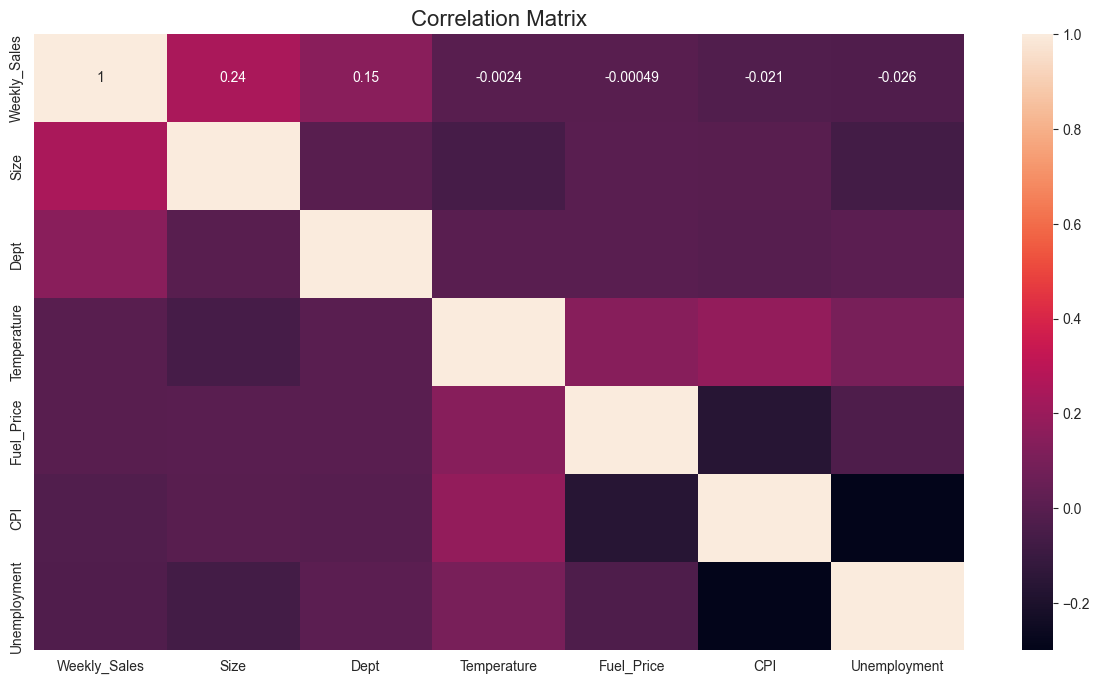

In [112]:
plt.figure(figsize=(15,8))
corr = df_train[numeric_col].corr()
sns.heatmap(corr, vmax=1.0, annot = True)
plt.title('Correlation Matrix', fontsize = 16)
plt.show()


- Size and Department can be seen the highest correlation with Weekly Sales

### Weekly Sales Histogram

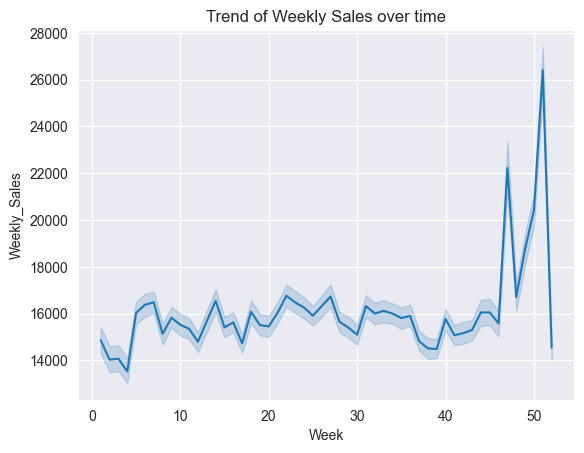

In [113]:
sns.lineplot(data = df_train, x = 'WeekOfYear', y = 'Weekly_Sales')
plt.xlabel('Week')
plt.ylabel('Weekly_Sales')
plt.title('Trend of Weekly Sales over time')
plt.show()

-  We can observe a huge hike between ThanksGiving and Christmas

### Average Weekly Sales Storewise

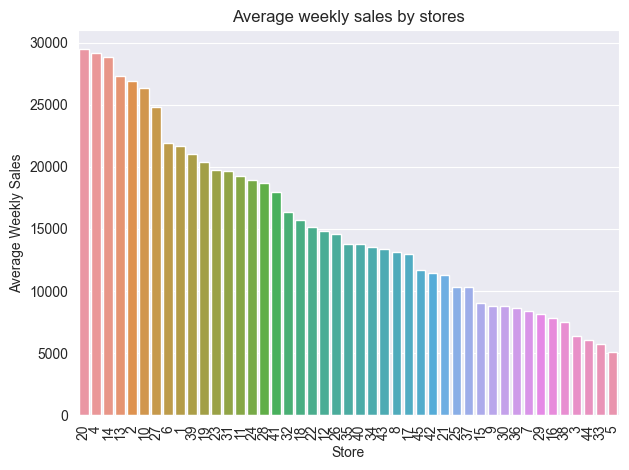

In [114]:
weekly_avg_sales = df_train.groupby('Store')['Weekly_Sales'].mean().reset_index()
sns.barplot(data=weekly_avg_sales, x = 'Store', y = 'Weekly_Sales', order = weekly_avg_sales.sort_values('Weekly_Sales', ascending = False)['Store'])
plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.title('Average weekly sales by stores')

plt.xticks(rotation = 90)
plt.tight_layout()

plt.show()

- Stores 20, 4, 14, 13 and Store no. 2 are the Top 5 Stores with High Avarage weekly sales

### Distribution of Weekly Sales

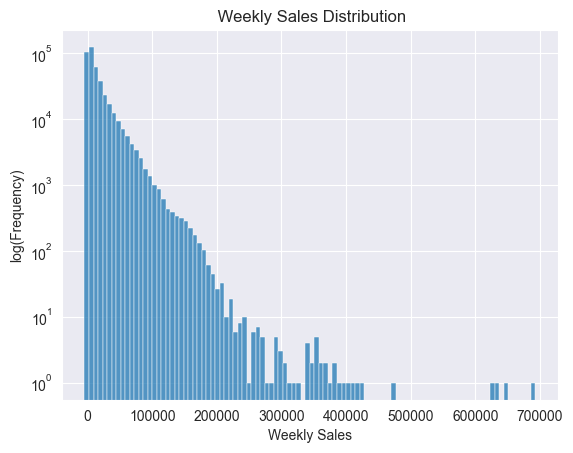

In [115]:
sns.histplot(data = df_train, x = 'Weekly_Sales', bins =  100)
plt.xlabel('Weekly Sales')
plt.ylabel('log(Frequency)')
plt.yscale('log')
plt.title(' Weekly Sales Distribution')
plt.show()


- Insight- More occurances of weekly sales in the lower end than the higher.

### Relationship between Temperature & weekly Sales

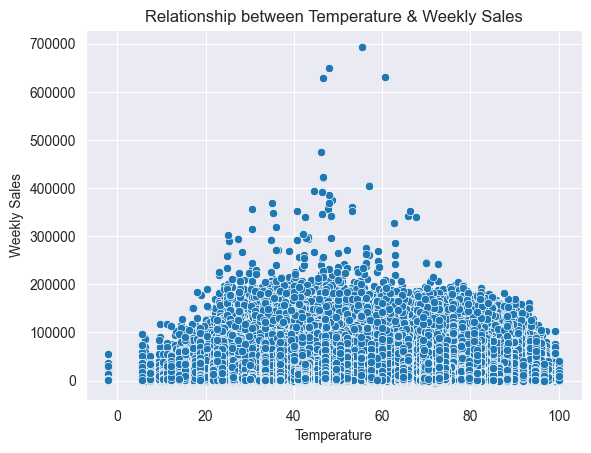

In [116]:
sns.scatterplot(data = df_train, x = 'Temperature', y = 'Weekly_Sales')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.title('Relationship between Temperature & Weekly Sales')
plt.show()




- Insights - Temperature between 30F- 70F, the weekly sales are high

### Weekly Sales based on the types of Stores

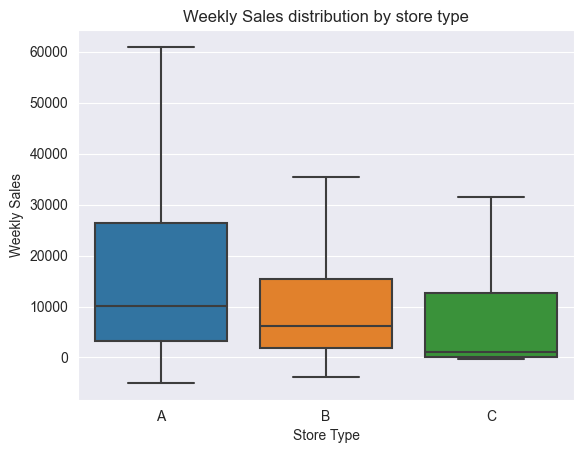

In [117]:
sns.boxplot(data = df_train, x = 'Type', y = 'Weekly_Sales', showfliers =  False)
plt.xlabel('Store Type')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales distribution by store type')
plt.show()


- Insights - Store Type A seems to have higher sales compared with B and C

### Weekly Sales distribution for holidays and non-holidays

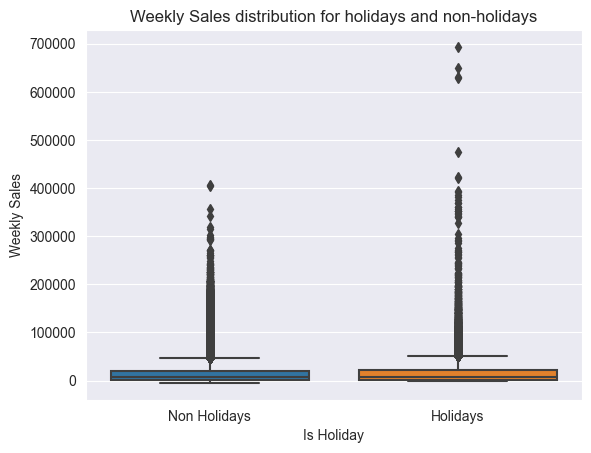

In [118]:
sns.boxplot(data = df_train, x = 'IsHoliday', y = 'Weekly_Sales')
plt.xlabel('Is Holiday')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales distribution for holidays and non-holidays')
plt.xticks([0,1], ['Non Holidays', 'Holidays'])
plt.show()


- Insights - More Outliers in Non Holidays compared to Holidays in a week

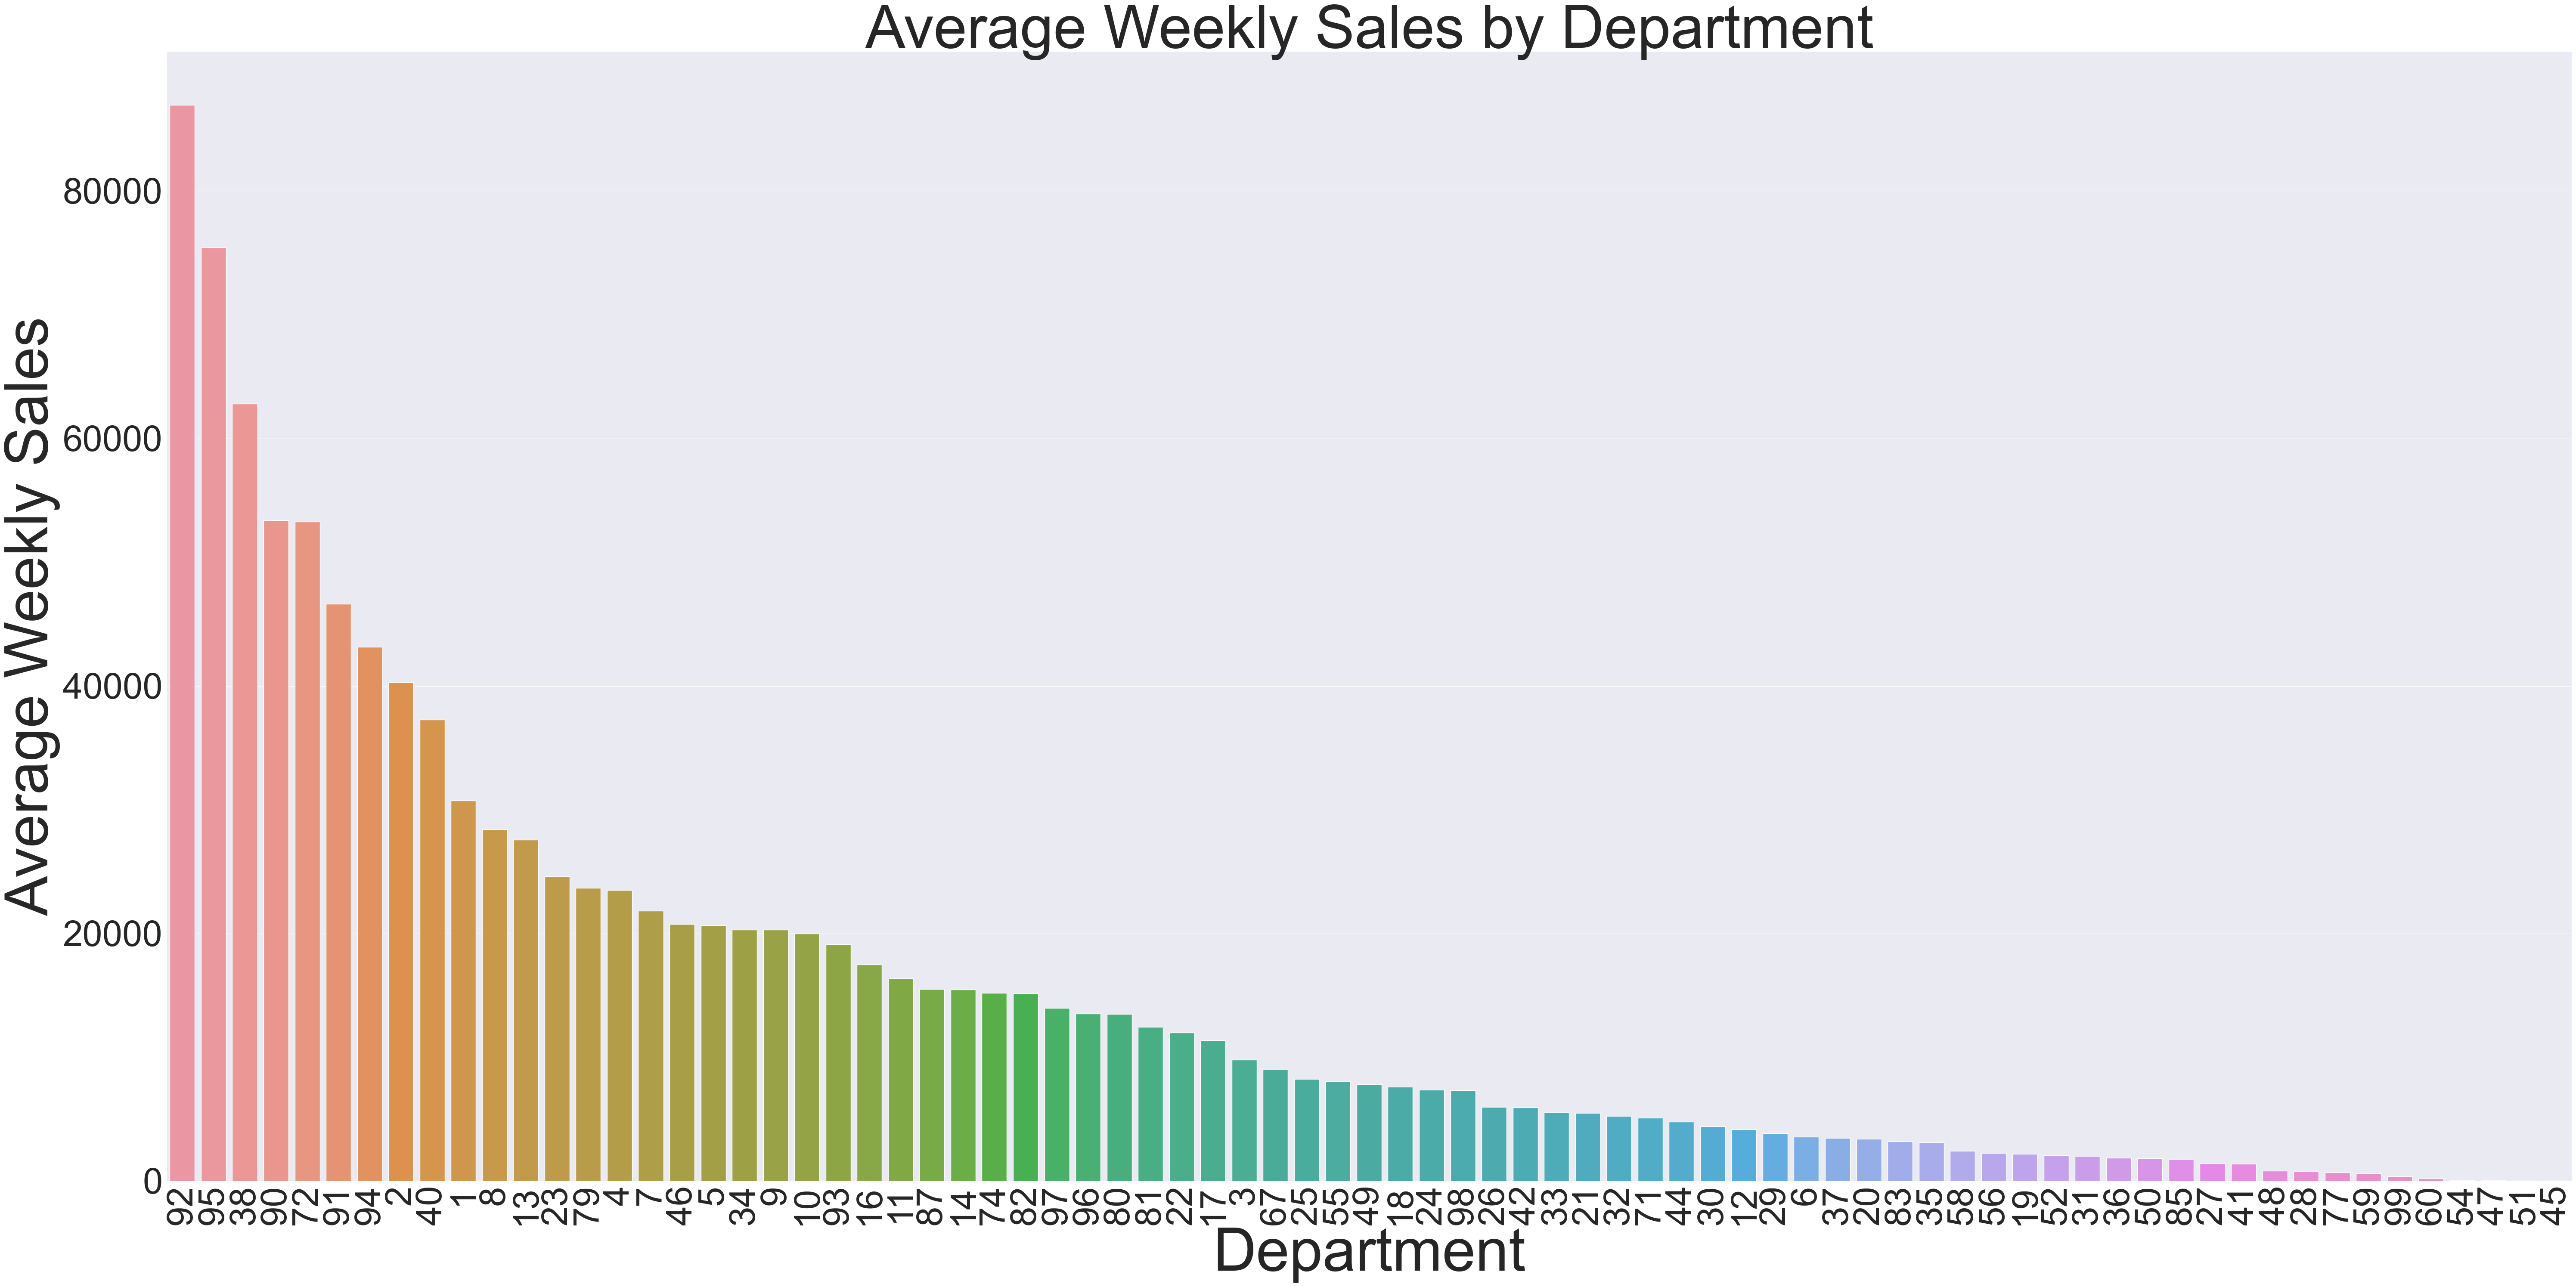

In [119]:
Avg_sales_storewise = df_train.sample(1000).groupby(['Dept'])['Weekly_Sales'].mean().reset_index()
plt.figure(figsize = (60,30))
sns.barplot(data = Avg_sales_storewise, x = 'Dept', y = 'Weekly_Sales', order = Avg_sales_storewise .sort_values('Weekly_Sales',ascending = False)['Dept'])
plt.xlabel('Department', fontsize = 100)
plt.ylabel('Average Weekly Sales', fontsize = 100)
plt.title('Average Weekly Sales by Department', fontsize = 100)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)
plt.xticks(rotation=90) 
plt.tight_layout()  # adjust lavel to prevent overlap
plt.show()


- Insights - The Top Departments are 92, 95, 90, 38 and 72

### Average Weekly sales Daywise

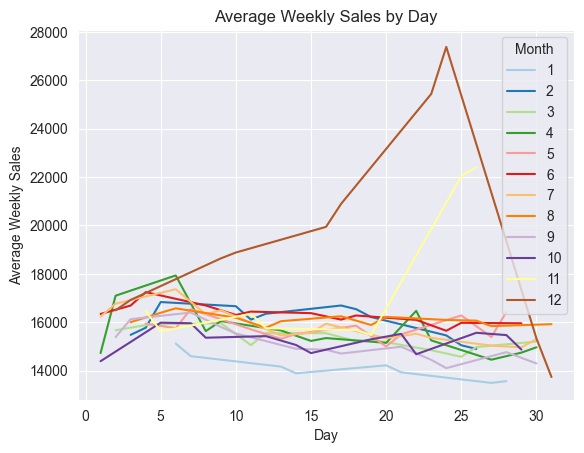

In [120]:
daywise_avg_weekly_sales =df_train.groupby(['Day', 'Month'])['Weekly_Sales'].mean().reset_index()

sns.lineplot(data = daywise_avg_weekly_sales, x='Day', y='Weekly_Sales', hue = 'Month', palette = sns.color_palette("Paired", 12))
plt.xlabel('Day')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Day')
plt.show()

- Insights - There are huge spike during Christmas

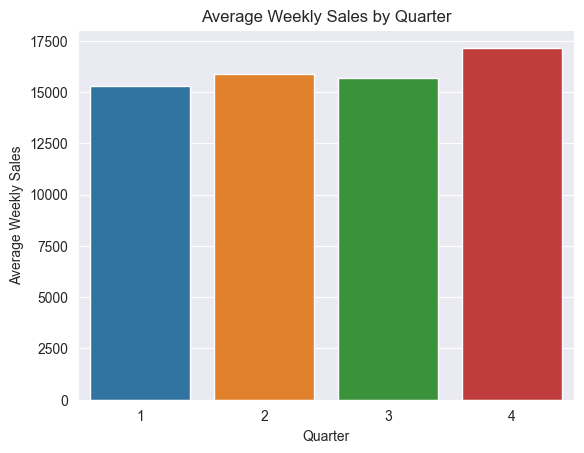

In [121]:
avg_sales_monthwise = df_train.groupby('Quarter')['Weekly_Sales'].mean().reset_index()
sns.barplot(data = avg_sales_monthwise, x ='Quarter', y = 'Weekly_Sales')
plt.xlabel('Quarter')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Quarter')
plt.show()


### Average weekly sales by year

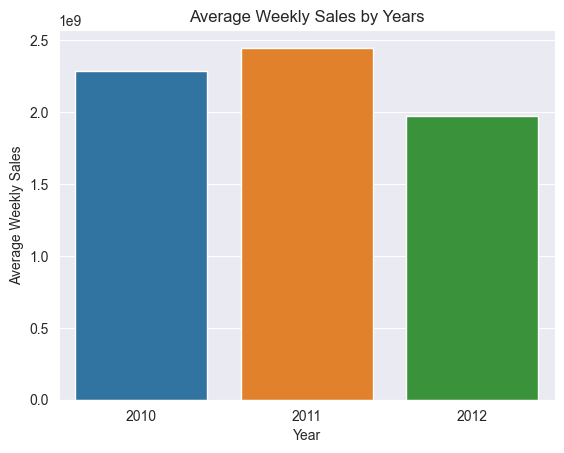

In [122]:
avg_sales_by_year = df_train.groupby('Year')['Weekly_Sales'].sum().reset_index()

sns.barplot(data=avg_sales_by_year, x='Year', y='Weekly_Sales')
plt.xlabel('Year')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Years')
plt.show()

- Insights - 2011 has the recorded highest sales

### Weekly Sales Vs. Store Type & Size

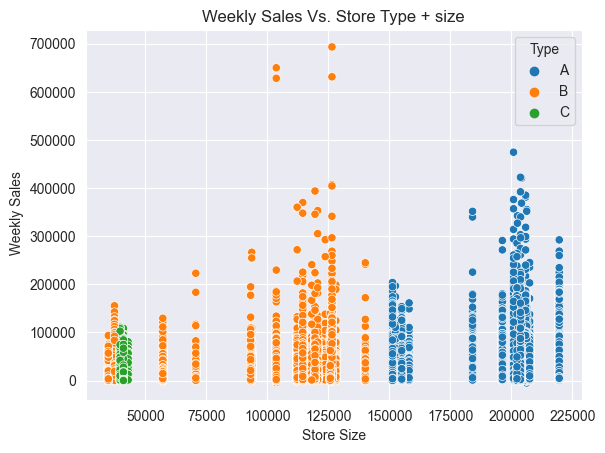

In [123]:
sns.scatterplot(data=df_train, x ='Size', y = 'Weekly_Sales', hue='Type')
plt.xlabel('Store Size')
plt.ylabel(' Weekly Sales')
plt.title('Weekly Sales Vs. Store Type + size')
plt.show()

- Insights - As  A is the bigger one store so sales is high as usual

### Weekly Sales Vs. Week Of the year

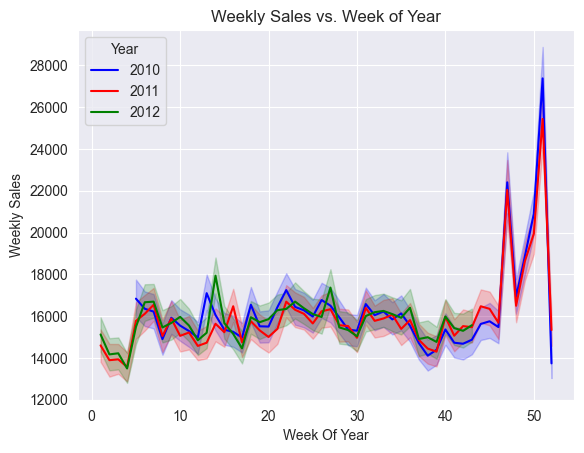

In [124]:
sns.lineplot(data=df_train, x='WeekOfYear', y = 'Weekly_Sales', hue = 'Year', palette = ['blue', 'red', 'green'])
plt.xlabel('Week Of Year')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales vs. Week of Year')
plt.show()

- Insights - Spikes can be seen during holidays

# 3. Preparing Train the models - Splitting into train test in a 70: 30 ratio
- Split Data
- Identify numeric & Categorical cols
- Identify Target col
- Imputetion Scaling,and Encoding


In [125]:
train_size = int(.70*len(df_train))
train, val = df_train[:train_size], train[train_size:]
train_size = int(.75 * len(df_train))
train,val = df_train[:train_size], df_train[train_size:]


In [126]:
len(train), len(val)

(315001, 105001)

### Identify Input columns and the Target

In [127]:
input_cols = ['Store', 'Dept', 'IsHoliday', 'Temperature','Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size', 'Day', 'Month','Year', 'WeekOfYear', 'Quarter']
target_col = 'Weekly_Sales'

In [128]:
train_inputs = df_train[input_cols].copy()
train_targets = df_train[target_col].copy()
val_inputs = val[input_cols].copy()
val_targets = val[target_col].copy()

test_inputs = df_test[input_cols].copy()

In [129]:
def numeric_cat_cols(data):
    num_cols  = data.select_dtypes(include = ['int64','float64']).columns.tolist()
    cat_cols = data.select_dtypes('object').columns.tolist()
    return num_cols, cat_cols
    

In [130]:
num_cols, cat_cols = numeric_cat_cols(train_inputs)

In [131]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
imputer = SimpleImputer(strategy='mean').fit(train_inputs[num_cols])
scaler = MinMaxScaler().fit(train_inputs[num_cols])
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[cat_cols])
encoded_cols = list(encoder.get_feature_names_out(cat_cols))

train_inputs[num_cols] = imputer.transform(train_inputs[num_cols])
val_inputs[num_cols] = imputer.transform(val_inputs[num_cols])
test_inputs[num_cols] = imputer.transform(test_inputs[num_cols])

train_inputs[num_cols] = scaler.transform(train_inputs[num_cols])
val_inputs[num_cols] = scaler.transform(val_inputs[num_cols])
test_inputs[num_cols] = scaler.transform(test_inputs[num_cols])

train_inputs[encoded_cols] = encoder.transform(train_inputs[cat_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[cat_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[cat_cols])

X_train = train_inputs[num_cols+encoded_cols]
X_val = val_inputs[num_cols+encoded_cols]
X_test = test_inputs[num_cols+encoded_cols]


# 4. Technology Implementation & train the Models
Linear Models
Having a regression problem, we are using the LinearRegression() as the base line model in Model Selection.Additionally we shall use the Ridge, Lasso, SGDRegressor and ElasticNet in order to conduct comprehensive performance comparison of all the models in sklearn. The function linear_models(model) which takes the models as input and performs training on trainin data. After completion the training and validation this returns the Root Mean Squired Errors.



### Linear Models

In [132]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

In [133]:
linear_models_scores = {}

In [134]:
def try_linear_models(model_name, model):
    
    model.fit(X_train, train_targets) # training the model on training data
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val) # model predictions on validation data
    
    # Training prediction scores
    train_mae = mean_absolute_error(train_targets, train_preds)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    train_r2 = r2_score(train_targets, train_preds)
    # validation prediction scores
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    val_r2 = r2_score(val_targets, val_preds)
    
    linear_models_scores[model_name] = {'mae':[round(train_mae,2), round(val_mae,2)],'rmse':[round(train_rmse,2), round(val_rmse,2)],'r2':[round(train_r2,2), round(val_r2,2)]}
    
    return val_mae, val_rmse, val_r2

In [135]:
model_names = ['linear', 'ridge', 'lasso', 'elasticnet', 'sgd']
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), SGDRegressor()]

for i in range(len(models)):
    
    val_mae, val_rmse, val_r2 = try_linear_models(model_names[i], models[i])




In [136]:
pd.DataFrame(linear_models_scores)

,linear,ridge,lasso,elasticnet,sgd
mae,"[14574.45, 14475.06]","[14568.68, 14468.89]","[14568.11, 14468.64]","[14803.0, 14711.06]","[14599.21, 14491.19]"
rmse,"[21678.25, 20930.13]","[21677.79, 20929.65]","[21677.8, 20929.82]","[22236.06, 21521.99]","[21678.26, 20931.16]"
r2,"[0.09, 0.1]","[0.09, 0.1]","[0.09, 0.1]","[0.04, 0.04]","[0.09, 0.1]"


-  The Linear Models have High mae and rmse scores and low r2 scores indicates that the linear models are not the best fit for the data.


### Ensemble Models
- Ensemble learning is a powerful and magical algorithm that is used by the data scientists accross the industry.The beuty behind is that the learning techniques. They combine the overall predictions of multiple machine learning models. Machine learning journey must include these techniques.
- a. Simple:
    These techniques includes: Random Forest,XGBoost, Gradient Boosting, LightGBM etc.
    The Simple and advanced ensemble learnings are :
        1. Max Volting
        2. Averaging
        3. Weighted Averaging

- b. Advanced:
        1. Stacking
        2. Blending
        3. Bagging
        4. Boosting

- Hence, we have used the XGBoost and LightGBM with default parameters for and initial train to see the better evaluation scores. The function try_ensemble_methods() takes in the model as input and returns the evaluated metrics.


In [137]:
!pip install lightgbm


In [138]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [139]:
rf_scores = {}
gb_scores = {}
ab_scores = {}
xgb_scores = {}
lgbm_scores = {}
trained_models = {}


In [140]:
def try_ensemble_methods(model_name, model, score_dict):
    
    model.fit(X_train, train_targets.values.ravel())
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    # Training prediction scores
    train_mae = mean_absolute_error(train_targets, train_preds)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    train_r2 = r2_score(train_targets, train_preds)
    # validation prediction scores
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    val_r2 = r2_score(val_targets, val_preds)
    
    score_dict['mae'] = {'training':round(train_mae,2), 'validation': round(val_mae,2)}
    score_dict['rmse'] = {'training':round(train_rmse,2), 'validation': round(val_rmse,2)}
    score_dict['r2'] = {'training':round(train_r2,2), 'validation': round(val_r2,2)}
    
    trained_models[model_name] = model
    
    return val_mae, val_rmse, val_r2


In [141]:
ensemble_models = [RandomForestRegressor(random_state=42, n_jobs=-1),
                  GradientBoostingRegressor(random_state=42),
                  AdaBoostRegressor(random_state=42),
                  XGBRegressor(random_state=42, n_jobs=-1),
                  LGBMRegressor(random_state=42, n_jobs=-1)]
ensemble_model_names = ['random_forest','gradient_boosting',
                       'adaboost','xgboost','lightgbm']
score_dicts = [rf_scores,gb_scores, ab_scores, xgb_scores, lgbm_scores]


for i in range(5):
    
    val_mae, val_rmse, val_r2 = try_ensemble_methods(ensemble_model_names[i], ensemble_models[i], score_dicts[i])
    print("*********")
    print(ensemble_model_names[i])
    print("Val MAE: ", val_mae)
    print("Val RMSE: ", val_rmse)
    print("Val R2: ", val_r2)



*********
random_forest
Val MAE:  548.5391853534728
Val RMSE:  1262.781758265302
Val R2:  0.9967095660873612
*********
gradient_boosting
Val MAE:  6457.14680813669
Val RMSE:  10050.727780651405
Val R2:  0.791554946132869
*********
adaboost
Val MAE:  15046.125176144498
Val RMSE:  19957.106788609766
Val R2:  0.17815155878577582
*********
xgboost
Val MAE:  2905.3317571847165
Val RMSE:  4901.469285863911
Val R2:  0.9504265499576238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 420002, number of used features: 10
[LightGBM] [Info] Start training from score 15977.012055
*********
lightgbm
Val MAE:  3859.4448102325746
Val RMSE:  6166.118400802667
Val R2:  0.9215450603225496


# 5. Model Evaluation

In [142]:
print("Random Forest scores")
display(pd.DataFrame(rf_scores))
print("XGBoost Scores")
display(pd.DataFrame(xgb_scores))
print("LightGBM Scores")
display(pd.DataFrame(lgbm_scores))
print("Gradient Boosting Scores")
display(pd.DataFrame(gb_scores))
print("AdaBoost Scores")
display(pd.DataFrame(ab_scores))

Random Forest scores


,mae,rmse,r2
training,686.95,2130.39,0.99
validation,548.54,1262.78,1.00


XGBoost Scores


,mae,rmse,r2
training,3205.97,6589.40,0.92
validation,2905.33,4901.47,0.95


LightGBM Scores


,mae,rmse,r2
training,4151.34,7785.36,0.88
validation,3859.44,6166.12,0.92


Gradient Boosting Scores


,mae,rmse,r2
training,6730.54,11564.90,0.74
validation,6457.15,10050.73,0.79


AdaBoost Scores


,mae,rmse,r2
training,15096.07,20236.56,0.21
validation,15046.13,19957.11,0.18


### Importance of Features

In [92]:
rf = trained_models['random_forest']
xgb = trained_models['xgboost']
lgbm = trained_models['lightgbm']

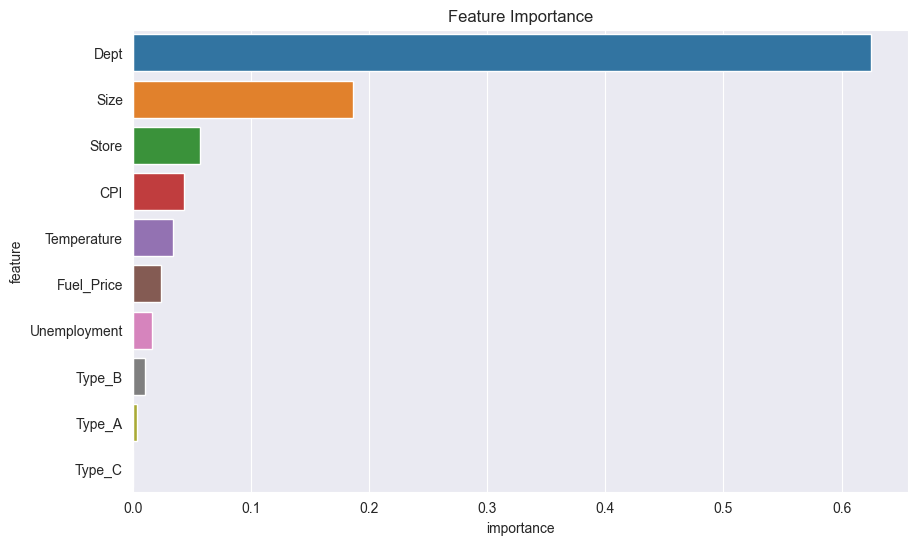

In [93]:
rf_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=rf_imp_df.head(10), x='importance', y='feature');

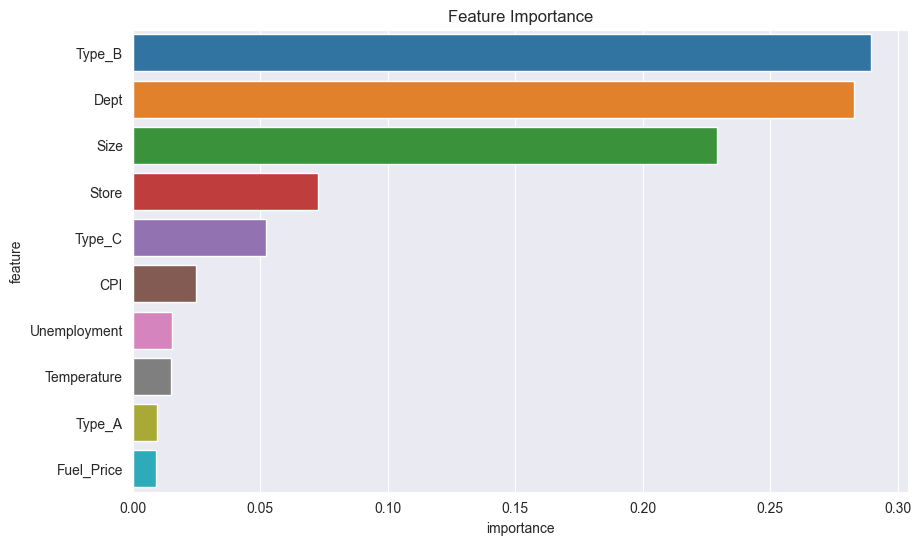

In [94]:
xgb_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=xgb_imp_df.head(10), x='importance', y='feature');

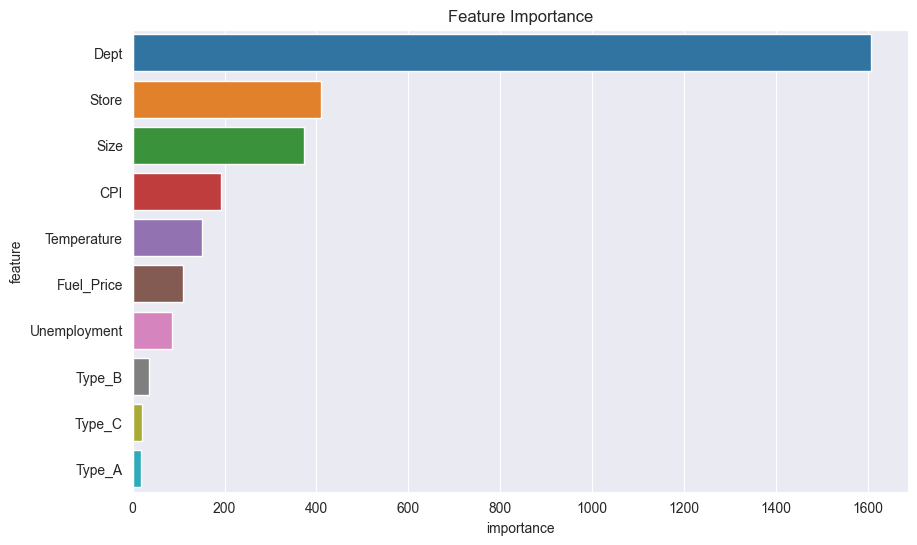

In [95]:
lgbm_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=lgbm_imp_df.head(10), x='importance', y='feature');

# 6. Hyperparameter Tuning
              n            ^
WMAE= 1/ ∑    ∑    wi | yi - yi|
         wi   i=1
         
         where,
         - n : Number of Rows
           ^
         - y : Predicted Sales
         - yi: Actual Sales
         - wi: Weights. 

In [143]:
def weighted_mean_absolute_error(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

In [144]:
train_weights = np.where(X_train['Temperature'] == 1, 5, 1)
val_weights = np.where(X_val['Temperature'] == 1, 5, 1)

In [145]:
models = {
    'randomforest': {
        'model': RandomForestRegressor,
        'params': {
            'max_depth': [5, 10, 15, 20, 25, 30, None],
            'n_estimators': [20, 50, 100, 150, 200, 250, 300,500],
            'min_samples_split': [2, 3, 4, 5, 10]
        }
    },
    'xgboost': {
        'model': XGBRegressor,
        'params': {
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'n_estimators': [30, 50, 100, 150, 200, 250, 300, 500],
            'learning_rate': [0.3, 0.2, 0.1, 0.01, 0.001]
        }
    },
    'lightgbm': {
        'model': LGBMRegressor,
        'params': {
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'n_estimators': [30, 50, 100, 150, 200, 250, 300, 500],
            'learning_rate': [0.3, 0.2, 0.1, 0.01, 0.001]
        }
    }
}

In [3]:
results = {}

def test_params(model_type, model, **params):
    model_instance = model(**params)
    model_instance.fit(X_train, train_targets)
    train_wmae = weighted_mean_absolute_error(model_instance.predict(X_train), train_targets, train_weights)
    val_wmae = weighted_mean_absolute_error(model_instance.predict(X_val), val_targets, val_weights)
    
    return train_wmae, val_wmae

def test_param_and_plot(model_type, model, param_name, param_values):
    
    train_errors, val_errors = [], []
    wmae_results = {}
    
    for value in param_values:
        params = {param_name: value}
        train_wmae, val_wmae = test_params(model_type, model, **params)
        
        train_errors.append(train_wmae)
        val_errors.append(val_wmae)
    
    plt.figure(figsize=(10, 6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('WMAE')
    plt.legend(['Training', 'Validation'])
    
    wmae_results[param_name] = {
            'train_wmae': train_errors,
            'val_wmae': val_errors
        }
    
    return wmae_results

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 420002, number of used features: 10
[LightGBM] [Info] Start training from score 15977.012055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 420002, number of used features: 10
[LightGBM] [Info] Start training from score 15977.012055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

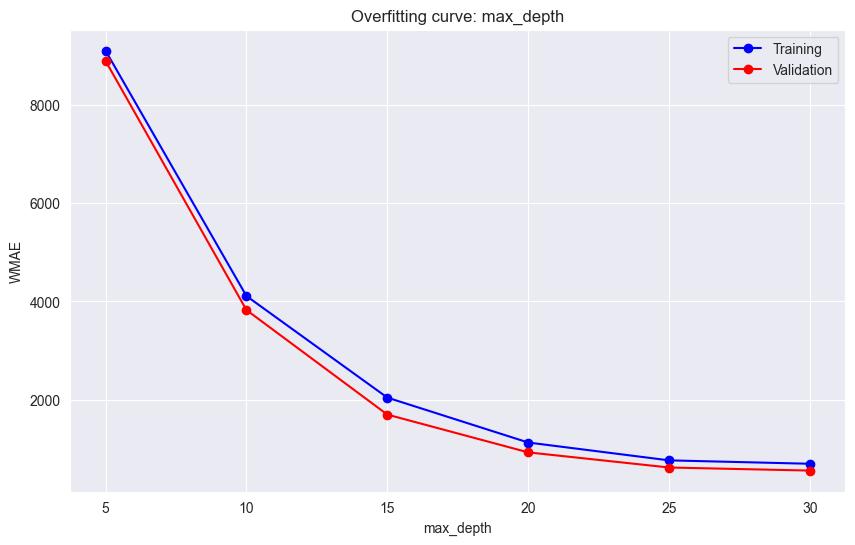

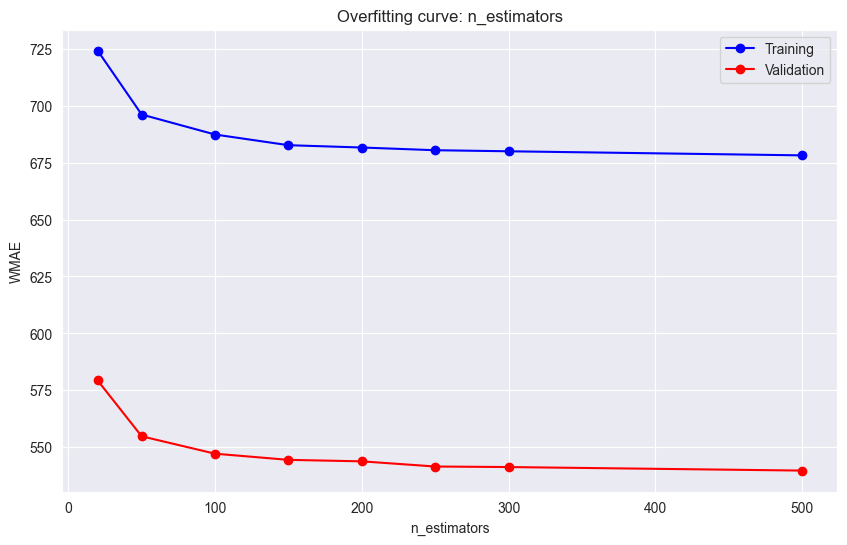

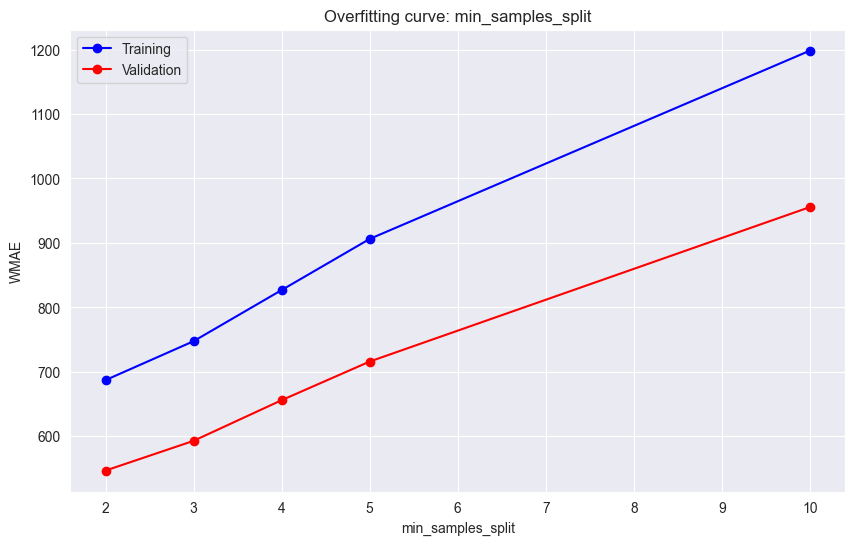

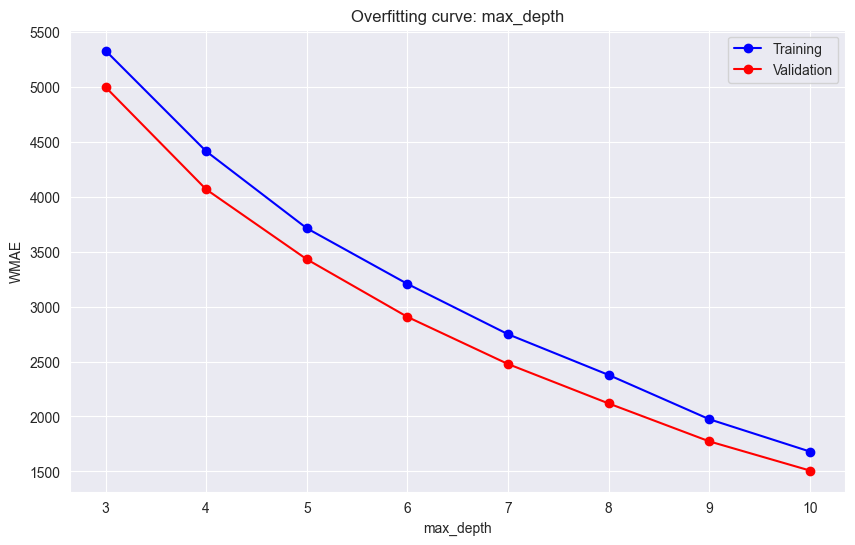

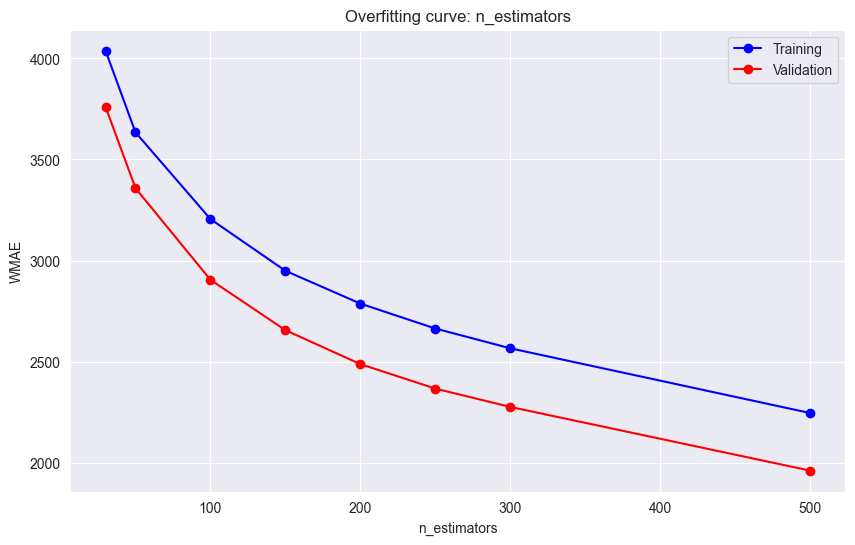

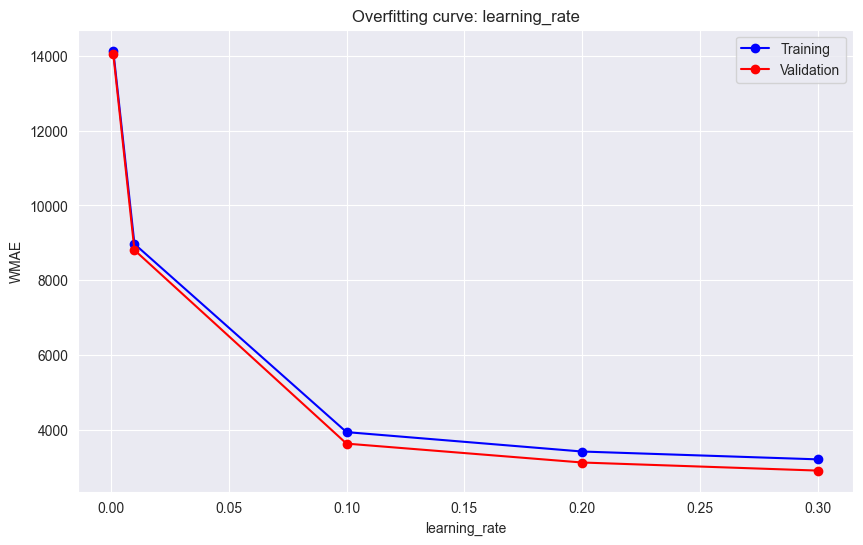

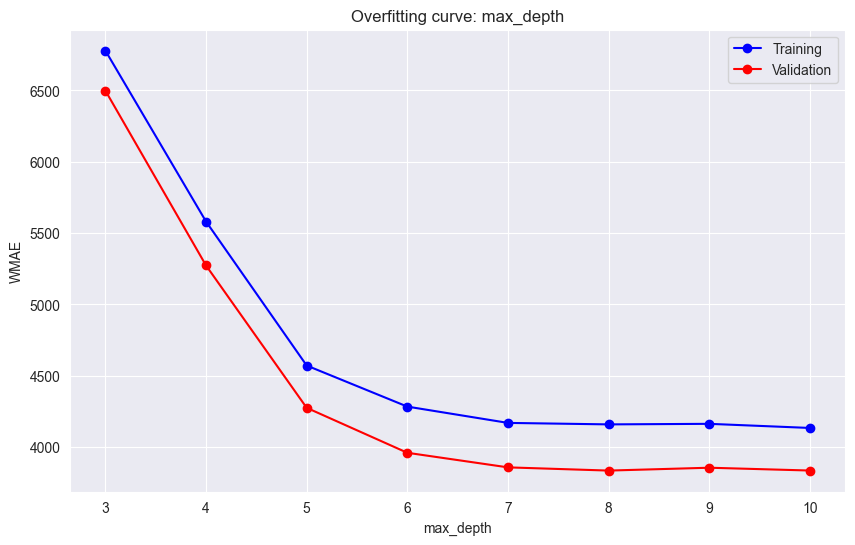

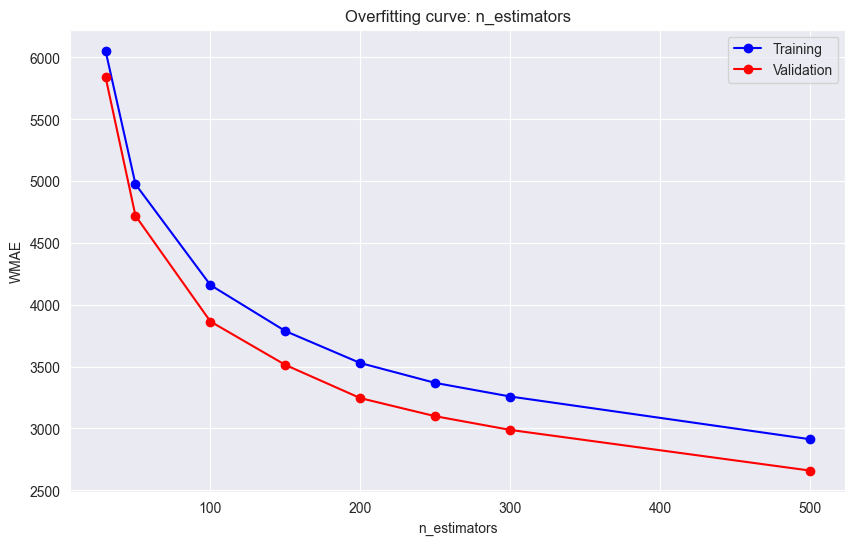

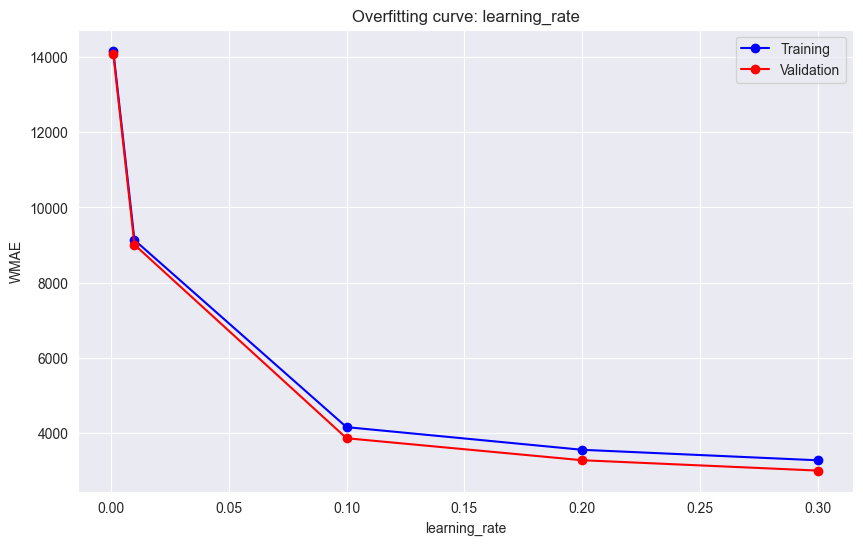

In [100]:
# Iterate over each model type
for model_type, config in models.items():
    model = config['model']
    params = config['params']
    
    # Iterate over each parameter and its values
    for param_name, param_values in params.items():
        wmae_results = test_param_and_plot(model_type, model, param_name, param_values)
        results[model_type + '_' + param_name] = wmae_results

# 7. Model Selection
 Hyperparameter tuning observation gives the result that the RandonForest is working the best. It's validation scores near about ~2000. Next we have tried the GridSearchCV to obtain the best fit RandomForest model.



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, train_targets)

best_model = grid_search.best_estimator_

scores = cross_val_score(best_model, X_train, train_targets, cv=5, scoring='neg_mean_absolute_error')
wmae_scores = -scores

best_model.fit(X_train, train_targets)

rf_val_wmae = weighted_mean_absolute_error(val_targets, best_model.predict(X_val), val_weights)

rf_val_wmae


In [ ]:
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)


xgb_param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}


In [ ]:
grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, train_targets)

xgb_best_model = grid_search.best_estimator_

scores = cross_val_score(xgb_best_model, X_train, train_targets, cv=5, scoring='neg_mean_absolute_error')
xgb_mae_scores = -scores
print("Cross-validation MAE scores:", xgb_mae_scores)
print("Mean MAE:", np.mean(xgb_mae_scores))

xgb_best_model.fit(X_train, train_targets)

print("Validation WMAE")
xgb_val_wmae = weighted_mean_absolute_error(val_targets, xgb_best_model.predict(X_val), val_weights)


xgb_val_wmae


In [ ]:
Saving Trained Models
We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the joblib module to save and load Python objects on the disk.

import joblib

walmart_sales = {
    'rf_model':best_model,
    'xgb_model':xgb_best_model,
    'imputer':imputer,
    'scaler':scaler,
    'encoder':encoder,
    'input_cols':input_cols,
    'target_cols':target_col,
    'numeric_cols':numeric_cols,
    'categorical_cols':categorical_cols,
    'encoded_cols':encoded_cols
}



# Conclusion
-This machine learning project, we have used Walmart stores historical data to predict weekly sales based on data given from last three years. As we want to predict a continuous variable, this project is an example of a regression problem. 

- The steps are as follows:
- 1. Download dataset from source
- 2. Read .csv file after converting from .zip
- 3. Feature Engineering performed - new date and time, markdown and holiday features were applied to the dataset.
- 4. Exploratory Data Analysis perfomed by checking the weekly sales and trends in weekly sales.
- 5. Then the data was prepared for the model training with train, test and validation splitting
- 6. Identify the numeric and categorical columns.
- 7. Scaling, imputation and encoding then done on the same data.
- 8. Model trained using linear model techniques but it was performed poorly.
- 9. Ensemble learning models are used like Random Forest, XGBoost and LightGBM
- 10. To get best fit model Hyperparameter tuning was used. Insight shows that the best performance was of Randomforest model.


- Comment: This project can be better with Time Series ARIMA model technique.